# HW3 **Q2**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os #loading file path
import torch
import pandas as pd
import spacy #tokenizer
from torch.nn.utils.rnn import pad_sequence #pad patch 
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from nltk import word_tokenize
from nltk import word_tokenize
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from google.colab import drive
import nltk
import requests
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import recall_score ,precision_score
from sklearn.metrics import f1_score
import copy
from sklearn.metrics import confusion_matrix

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/colab/DL_3/Q2/"

glove.42B.300d.txt  Q2_V6.ipynb			SemEval2010_task8_all_data.zip
glove.42B.300d.zip  Q2_V7.ipynb
Q2-V2.ipynb	    SemEval2010_task8_all_data


# ***download*** and preparing  dataset

In [ ]:
#dwonloadin dataset
file_url = "https://drive.google.com/u/0/uc?id=0B_jQiLugGTAkMDQ5ZjZiMTUtMzQ1Yy00YWNmLWJlZDYtOWY1ZDMwY2U4YjFk&export=download"
r = requests.get(file_url, stream = True)

with open("/content/drive/My Drive/colab/DL_3/Q2/SemEval2010_task8_all_data.zip", "wb") as file:
	for block in r.iter_content(chunk_size = 1024):
		if block:
			file.write(block)


In [ ]:
#unzip dataset to My drive
!unzip "/content/drive/My Drive/colab/DL_3/Q2/SemEval2010_task8_all_data.zip" -d  "/content/drive/My Drive/colab/DL_3/Q2/"

In [ ]:
!ls "/content/drive/My Drive/colab/DL_3/Q2/SemEval2010_task8_all_data/SemEval2010_task8_training"

README.txt	      Task8_Relation4.pdf  Task8_Relation9.pdf
Task8_Guidelines.pdf  Task8_Relation5.pdf  TRAIN_DISTRIB.TXT
Task8_Relation1.pdf   Task8_Relation6.pdf  TRAIN_FILE.TXT
Task8_Relation2.pdf   Task8_Relation7.pdf  TRAIN_TEST_DISTRIB.TXT
Task8_Relation3.pdf   Task8_Relation8.pdf


In [ ]:
#dwonload glove to My drive
file_url = "https://nlp.stanford.edu/data/glove.42B.300d.zip"
r = requests.get(file_url, stream = True)

with open("/content/drive/My Drive/colab/DL_3/Q2/glove.42B.300d.zip", "wb") as file:
	for block in r.iter_content(chunk_size = 1024):
		if block:
			file.write(block)


In [ ]:
#unzip Glove toMy drive
!unzip "/content/drive/My Drive/colab/DL_3/Q2/glove.42B.300d.zip" -d  "/content/drive/My Drive/colab/DL_3/Q2/

# **data** preprocessing


In [ ]:
#class vocabulary : buids two dictionary of vocab and their indexes + finds entitie's index
class Vocabulary:

  def __init__(self ):
    
    self.itos = {0: "<PAD>", 1: "<UNK>"}
    self.stoi = {"<PAD>": 0, "<UNK>": 1}
    

  def __len__(self):
      return len(self.itos)
    

  @staticmethod
  def tokenizer(text):
        return  word_tokenize(text.lower()) #lower case vocabs
 

  def vocab_maker(self ,sentences): #list of words 
        check_word = {} #checking vocab have been seen or it's new 
        index = 2


        for sentence in sentences: #each sentence in sentence list
          for i , word in enumerate(self.tokenizer(sentence)):
            
                if word in check_word:
                    check_word[word] += 1
                else :
                    check_word[word] = 1

                if check_word[word] == 1:
                    self.itos[index] = word
                    self.stoi[word] = index
                    index += 1
      

  def entities(self, sentences):  #index of entiites
        entities = []


        for sentence in sentences: #each sentence in sentence list
          entitie = []
          for i , word in enumerate(self.tokenizer(sentence)):
  
                if "e1_start" in word : #finding index od entities
                  entitie.append(self.stoi[word])
                elif "e1_end" in word :
                  entitie.append(self.stoi[word])
                elif "e2_start" in word :
                  entitie.append(self.stoi[word])
                elif "e2_end" in word :
                  entitie.append(self.stoi[word])
          entities.append(entitie)
        return entities

      
  def convert_to_num(self , text):  # conver vocabs to number using stoi dictionary

        tokenised = self.tokenizer(text)
        return [
              self.stoi[token] 
              if token in self.stoi 
              else self.stoi['<UNK>'] 
              for token in tokenised 
        ]

In [ ]:
#dataset : returns three item :1:the setences as vectore 2:labels -> the class number and indexs of start and end of etiites
class SemDataset_test(Dataset):

  def __init__(self ,root_dir , phase  , dataset,transform = None):
      self.label = []
      self.sentences = []
      self.num = []
      #self.sentence_vectore = []
      self.root_dir = root_dir
      self.entities = []

      self.lines = [line.strip() for line in open(root_dir)]
      length = len(self.lines)

      for idx in range(0,length,4):
          self.label.append(self.lines[idx+1].split("(")[0])
          self.num.append(self.lines[idx].split('\t')[0])
          sentence = self.lines[idx].split('\t')[1][1:-1]
          sentence = sentence.replace("<e1>", " E1_START ").replace("</e1>", " E1_END ") #replacing and use some white spaces
          sentence = sentence.replace("<e2>", " E2_START ").replace("</e2>", " E2_END ")
          self.sentences.append(sentence)


      self.vocab = Vocabulary()
      self.entities = self.vocab.entities(self.sentences)
      self.cton = {"Cause-Effect":0, "Instrument-Agency":1, "Product-Producer":2 , "Content-Container":3 , "Entity-Origin":4, "Entity-Destination":5 , "Component-Whole":6 , "Member-Collection":7 , "Message-Topic":8 , "Other":9}
      self.ntoc = {0:"Cause-Effect", 1:"Instrument-Agency", 2:"Product-Producer" , 3:"Content-Container" , 4:"Entity-Origin",5:"Component-Whole" , 6:"Member-Collection" , 7:"Message-Topic" , 8:"Other"}

  def __len__(self):
      return(len(self.label))

  def __getitem__(self,idx):

      if torch.is_tensor(idx):
          idx = idx.tolist()

      label = self.label[idx]
      
      sentence = self.sentences[idx]

      sentence_vectore = self.vocab.convert_to_num(sentence)
      entities = self.entities[idx]


      return torch.tensor(sentence_vectore) , self.cton[label] , entities


In [ ]:
path = "/content/drive/My Drive/colab/DL_3/Q2/SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT"
test_path = "/content/drive/My Drive/colab/DL_3/Q2/SemEval2010_task8_all_data/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT"

dataset = SemDataset(path , "train") #making datasets

In [ ]:
#dataset : returns three item :1:the setences as vectore 2:labels -> the class number and indexs of start and end of etiites
#dataset for test data using indexes of trianing data for our vocabulry
class SemDataset_test(Dataset):

  def __init__(self ,root_dir ,dataset, phase  ,transform = None):
      self.label = []
      self.sentences = []
      self.num = []
      #self.sentence_vectore = []
      self.root_dir = root_dir
      self.entities = []

      self.lines = [line.strip() for line in open(root_dir)]
      length = len(self.lines)
      for idx in range(0,length,4):
          self.label.append(self.lines[idx+1].split("(")[0])
          self.num.append(self.lines[idx].split('\t')[0])
          sentence = self.lines[idx].split('\t')[1][1:-1]
          sentence = sentence.replace("<e1>", " E1_START ").replace("</e1>", " E1_END ") #replacing and use some white spaces
          sentence = sentence.replace("<e2>", " E2_START ").replace("</e2>", " E2_END ")
          self.sentences.append(sentence)


      self.vocab = dataset.vocab # access to train vocabulary and their ndexes
      self.entities = self.vocab.entities(self.sentences)
      self.cton = {"Cause-Effect":0, "Instrument-Agency":1, "Product-Producer":2 , "Content-Container":3 , "Entity-Origin":4, "Entity-Destination":5 , "Component-Whole":6 , "Member-Collection":7 , "Message-Topic":8 , "Other":9}
      self.ntoc = {0:"Cause-Effect", 1:"Instrument-Agency", 2:"Product-Producer" , 3:"Content-Container" , 4:"Entity-Origin",5:"Component-Whole" , 6:"Member-Collection" , 7:"Message-Topic" , 8:"Other"}

  def __len__(self):
      return(len(self.label))

  def __getitem__(self,idx):

      if torch.is_tensor(idx):
          idx = idx.tolist()

      label = self.label[idx]
      
      sentence = self.sentences[idx]

      sentence_vectore = self.vocab.convert_to_num(sentence)
      entities = self.entities[idx]


      return torch.tensor(sentence_vectore) , self.cton[label] , entities

In [ ]:
test_dataset = SemDataset_test(test_path ,dataset,"test")

In [ ]:
#class for padding sentences , every sentences in a batch have same lenght as largest sentence
class Collate_fn:

    def __init__(self , idx , batch_first):

        self.idx = idx
        self.batch_first = batch_first
    def __call__(self,batch):

        sentence = [item[0] for item in batch]
        sentence = pad_sequence(sentence , padding_value=self.idx , batch_first = self.batch_first ) #usin pas_sequence for padding

        
        label = [item[1] for item in batch]
        entities = [item[2] for item in batch]
        

        return sentence,torch.tensor(label),torch.tensor(entities)

In [ ]:
# Creating data indices for training and validation splits:  code from internet
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887
val_split = 0.1
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(val_split * dataset_size))
if shuffle_dataset :
    np.random.seed(42)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)


Dataloaders

In [ ]:
#usin dictionary for train and validation dataloadeer .
dataloaders = {"train": DataLoader(dataset, 
                        batch_size = 128,
                        sampler=train_sampler, #split data
                        #shuffle = True, 
                        num_workers = 4,
                        pin_memory = True,
                        collate_fn = Collate_fn(idx=dataset.vocab.stoi["<PAD>"],batch_first=True),
                      ),
                "val": DataLoader(dataset, 
                        batch_size = 64,
                        sampler=val_sampler,
                        #shuffle = True, 
                        num_workers = 4,
                        pin_memory = True,
                        collate_fn = Collate_fn(idx=dataset.vocab.stoi["<PAD>"],batch_first=True),
                        )
                        }

test_loader = DataLoader(test_dataset, 
                        batch_size = 64,
                        #shuffle = True, 
                        num_workers = 4,
                        collate_fn = Collate_fn(idx=test_dataset.vocab.stoi["<PAD>"],batch_first=True),
                        )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# **Network**

# First Part : finetuning and random initialization for embedding matrix

In [ ]:
# random initialization 
vocab_size = len(dataset.vocab)
embed_size = 100
embedding_matrix = np.random.randn(vocab_size,embed_size)
embedding_matrix.shape

(18629, 100)

In [ ]:
class Network(nn.Module):

    def __init__(self , vocab_size , embed_size , hidden_size , num_layers=2 , weight = False): #weight for fintuning or fixed the gradiant(boolean)
      super(Network , self).__init__()
    
      self.embedding = nn.Embedding(vocab_size , embed_size)
      self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
      self.embedding.weight.requires_grad = weight
      self.lstm = nn.LSTM(embed_size , hidden_size , num_layers = num_layers , batch_first = True, bidirectional = True)
      self.linear =nn.Linear(hidden_size*2,10)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self ,x):
      x = self.embedding(x) 
      #print("embedding",x.shape)
      packed_output , (hidden,cell) = self.lstm(x)
      #print("packed_out",)
      #print("lstm hidden",hidden.shape)
      cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
      #print("cat",cat.shape)
      x = self.linear(cat)
      #print("linear",x.shape)
      output = self.softmax(x)
      #print("ouutput",output.shape)
      return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
embed_size = 100
hidden_size = 150
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 1e-4

In [ ]:
model = Network(vocab_size, embed_size, hidden_size,  num_layers, weight=True).to(device)
model.to(device)
criterion = nn.NLLLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
#accuracy function 
def accuracy(outputs_acc,labels):

    total =len(labels)
    return ((total-torch.count_nonzero(torch.subtract(labels,outputs_acc)))/total)


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_acc = 0.0

            # Iterate over data.
            for i, (sentences,labels,entities)  in enumerate(iter(dataloaders[phase])):
                sentences = sentences.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(sentences)
                    #print(outputs.shape)
                    outputs_acc = torch.argmax(outputs,dim=1)
                    # Calculate the batch loss.
                    loss = criterion(outputs,labels)
                    acc = accuracy(labels,outputs_acc)



                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() 
                running_acc += acc.item()
            if phase == 'train':
                #scheduler.step()
                print("LR:{}".format(optimizer.param_groups[0]['lr']))
            
            epoch_loss = running_loss / i
            epoch_acc = running_acc / i
            if phase=="train":
              loss_train.append(epoch_loss)
              acc_train.append(epoch_acc)
            else:
              loss_val.append(epoch_loss)
              acc_val.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' :
                best_model_wts = copy.deepcopy(model.state_dict())

    #calculatin time
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    model.load_state_dict(best_model_wts)

    return model ,loss_train,loss_val,acc_train,acc_val 

In [ ]:
model_a , loss_train_a , loss_val_a , acc_train_a , acc_val_a = train_model(model, criterion, optimizer, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR:0.0001
train Loss: 2.2751 Acc: 0.1596
val Loss: 2.3727 Acc: 0.1836
Epoch 1/24
----------
LR:0.0001
train Loss: 2.2080 Acc: 0.1630
val Loss: 2.3389 Acc: 0.1721
Epoch 2/24
----------
LR:0.0001
train Loss: 2.1681 Acc: 0.1679
val Loss: 2.2121 Acc: 0.2291
Epoch 3/24
----------
LR:0.0001
train Loss: 1.9637 Acc: 0.2729
val Loss: 1.9584 Acc: 0.3557
Epoch 4/24
----------
LR:0.0001
train Loss: 1.7537 Acc: 0.3363
val Loss: 1.7961 Acc: 0.4026
Epoch 5/24
----------
LR:0.0001
train Loss: 1.5927 Acc: 0.3907
val Loss: 1.6458 Acc: 0.4436
Epoch 6/24
----------
LR:0.0001
train Loss: 1.4534 Acc: 0.4452
val Loss: 1.5442 Acc: 0.4864
Epoch 7/24
----------
LR:0.0001
train Loss: 1.3587 Acc: 0.4758
val Loss: 1.4373 Acc: 0.5148
Epoch 8/24
----------
LR:0.0001
train Loss: 1.2801 Acc: 0.5125
val Loss: 1.3963 Acc: 0.5377
Epoch 9/24
----------
LR:0.0001
train Loss: 1.2175 Acc: 0.5278
val Loss: 1.5235 Acc: 0.4858
Epoch 10/24
----------
LR:0.0001
train Loss: 1.1483 Acc: 0.5565
val Loss: 1.3783 Acc: 0.5446
Epoch 11/

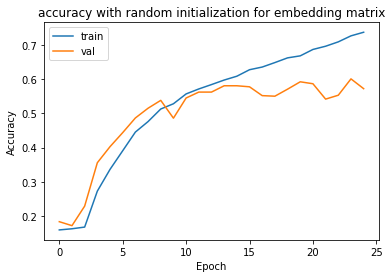

In [ ]:
#plt.plot(loss_train)
plt.plot(acc_train_a)
plt.plot(acc_val_a)
plt.title('accuracy with random initialization for embedding matrix')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val']);

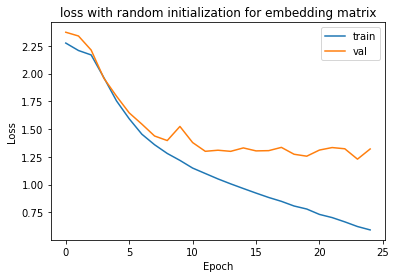

In [ ]:
#plt.plot(loss_train)
plt.plot(loss_train_a)
plt.plot(loss_val_a)
plt.title('loss with random initialization for embedding matrix')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val']);

In [ ]:
def visualize_model(model):
    y_true = []
    y_pred = []
    running_acc = 0.0
    #with torch.no_grad():
    for i, (sentences,labels,entities)  in enumerate(iter(test_loader)):
            sentences = sentences.to(device)
            labels = labels.to(device)

            outputs = model(sentences)
            outputs_acc = torch.argmax(outputs,dim=1)
            acc = accuracy(labels,outputs_acc)
            running_acc += acc.item()
            for out in outputs_acc:
              y_pred.append(out.tolist())    
            for true in labels:
              y_true.append(true.tolist())


    acc = running_acc / i
    print("test accuray : ",acc)
    recall = recall_score(y_true, y_pred, average='macro')
    print("Recall: " , recall)
    precision = precision_score(y_true, y_pred, average='macro')
    print("Precision: " , precision)
    f1 = f1_score(y_true, y_pred, average='macro')
    print("f1_score: " , f1)


In [ ]:
visualize_model(model_a)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test accuray :  0.5334436574152538
Recall:  0.5527726377931879
Precision:  0.5002285835522281
f1_score:  0.5226583279503862


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **second** **part** :fix feature extractore and using glove for embedding matrix

In [ ]:
#//www.kaggle.com/gmhost/gru-capsule
max_features = len(dataset.vocab)
def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/My Drive/colab/DL_3/Q2/glove.42B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:100]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for i, word in enumerate(word_index):
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
embedding_matrix = load_glove(dataset.vocab.stoi)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
embed_size = 100
hidden_size = 150
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 1e-4

In [ ]:
model = Network(vocab_size, embed_size, hidden_size,  num_layers , weight = False)
model.to(device)
criterion = nn.NLLLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_b , loss_train_b , loss_val_b , acc_train_b , acc_val_b = train_model(model, criterion, optimizer, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR:0.0001
train Loss: 2.2819 Acc: 0.1456
val Loss: 2.3796 Acc: 0.1605
Epoch 1/24
----------
LR:0.0001
train Loss: 2.2034 Acc: 0.1638
val Loss: 2.3257 Acc: 0.1879
Epoch 2/24
----------
LR:0.0001
train Loss: 2.1331 Acc: 0.1904
val Loss: 2.2425 Acc: 0.2376
Epoch 3/24
----------
LR:0.0001
train Loss: 2.0148 Acc: 0.2414
val Loss: 2.0773 Acc: 0.3115
Epoch 4/24
----------
LR:0.0001
train Loss: 1.8521 Acc: 0.3148
val Loss: 1.8924 Acc: 0.3744
Epoch 5/24
----------
LR:0.0001
train Loss: 1.7327 Acc: 0.3500
val Loss: 1.7937 Acc: 0.4282
Epoch 6/24
----------
LR:0.0001
train Loss: 1.6363 Acc: 0.3856
val Loss: 1.7397 Acc: 0.4407
Epoch 7/24
----------
LR:0.0001
train Loss: 1.5332 Acc: 0.4234
val Loss: 1.5810 Acc: 0.4793
Epoch 8/24
----------
LR:0.0001
train Loss: 1.4477 Acc: 0.4505
val Loss: 1.4755 Acc: 0.5020
Epoch 9/24
----------
LR:0.0001
train Loss: 1.3776 Acc: 0.4747
val Loss: 1.5227 Acc: 0.4886
Epoch 10/24
----------
LR:0.0001
train Loss: 1.3227 Acc: 0.4886
val Loss: 1.3912 Acc: 0.5534
Epoch 11/

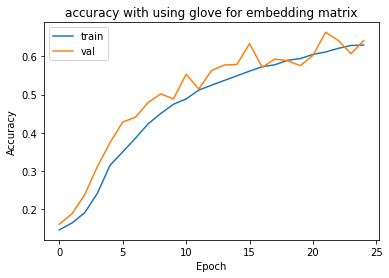

In [ ]:
#plt.plot(loss_train)
plt.plot(acc_train_b)
plt.plot(acc_val_b)
plt.title('accuracy with using glove for embedding matrix')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val']);

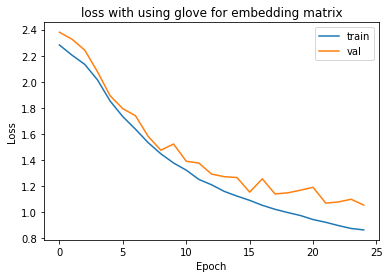

In [ ]:
#plt.plot(loss_train)
plt.plot(loss_train_b)
plt.plot(loss_val_b)
plt.title('loss with using glove for embedding matrix')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val']);

In [ ]:
visualize_model(model_b)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test accuray :  0.5590491578692481
Recall:  0.5902075254428942
Precision:  0.5025559798829933
f1_score:  0.5346123155385903


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Thired part** : fix feature extractore and using glove for embedding matrix using just entities

In [ ]:
class Network(nn.Module):

    def __init__(self , vocab_size , embed_size , hidden_size , num_layers=2 , weight = False):
      super(Network , self).__init__()
    
      self.embedding = nn.Embedding(vocab_size , embed_size)
      self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
      self.embedding.weight.requires_grad = weight
      self.lstm = nn.LSTM(embed_size , hidden_size , num_layers = num_layers , batch_first = True, bidirectional = True)
      self.linear =nn.Linear(hidden_size*2,10)
      self.softmax = nn.LogSoftmax(dim=1)
      self.hidden_size = hidden_size
      self.max = nn.MaxPool1d(2,stride = 2)

    def forward(self, x, entities):
              
        entity_list = []
        #print("all entities",entities)
        h_embedding = self.embedding(x)   #128*61*100
        packed_output, (hidden, cell) = self.lstm(h_embedding)  #128*61*300(hidden_size*2)
        output = self.max(packed_output)  #128*61*150 
        
        for i in range(x.size(0)):
          e1_indexes = [i for i in entities[i][0:2]]
          #print("e1" ,e1_indexes)
          e2_indexes = [i for i in entities[i][2:]]
          #print("dfdf",output[i,e1_indexes[0]+1:e1_indexes[1],:].shape)
          m1 = torch.mean(output[i,e1_indexes[0]+1:e1_indexes[1],:], dim=0)
          m2 = torch.mean(output[i,e2_indexes[0]+1:e2_indexes[1],:], dim=0)

          entity_list.append(torch.cat((m1,m2), dim=0))
          cat = torch.stack(entity_list)
          final = self.softmax(self.linear(cat))
      
        return final

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
embed_size = 100
hidden_size = 150
vocab_size = len(dataset.vocab)
num_layers = 2
learning_rate = 1e-4

In [ ]:
model = Network(vocab_size, embed_size, hidden_size,  num_layers, weight=False).to(device)
model.to(device)
criterion = nn.NLLLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_model_c(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())

    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_acc = 0.0

            # Iterate over data.
            for i, (sentences,labels,entities)  in enumerate(iter(dataloaders[phase])):
                sentences = sentences.to(device)
                labels = labels.to(device)
                entities = entities.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(sentences , entities)
                    #print(outputs.shape)
                    outputs_acc = torch.argmax(outputs,dim=1)
                    # Calculate the batch loss.
                    loss = criterion(outputs,labels)
                    acc = accuracy(labels,outputs_acc)



                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() 
                running_acc += acc.item()
            if phase == 'train':
                #scheduler.step()
                print("LR:{}".format(optimizer.param_groups[0]['lr']))
            
            epoch_loss = running_loss / i
            epoch_acc = running_acc / i
            if phase=="train":
              loss_train.append(epoch_loss)
              acc_train.append(epoch_acc)
            else:
              loss_val.append(epoch_loss)
              acc_val.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' :
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(best_model_wts)

    return model , loss_train,loss_val,acc_train,acc_val

In [ ]:
model_c , loss_train_c , loss_val_c , acc_train_c , acc_val_c = train_model_c(model, criterion, optimizer, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR:0.0001
train Loss: 2.2768 Acc: 0.1663
val Loss: 2.3321 Acc: 0.2190
Epoch 1/24
----------
LR:0.0001
train Loss: 2.1310 Acc: 0.1984
val Loss: 2.2481 Acc: 0.2405
Epoch 2/24
----------
LR:0.0001
train Loss: 2.0976 Acc: 0.2126
val Loss: 2.2270 Acc: 0.2332
Epoch 3/24
----------
LR:0.0001
train Loss: 2.0705 Acc: 0.2178
val Loss: 2.1784 Acc: 0.2845
Epoch 4/24
----------
LR:0.0001
train Loss: 1.9542 Acc: 0.2547
val Loss: 1.9944 Acc: 0.3529
Epoch 5/24
----------
LR:0.0001
train Loss: 1.8345 Acc: 0.3016
val Loss: 1.8594 Acc: 0.3870
Epoch 6/24
----------
LR:0.0001
train Loss: 1.6844 Acc: 0.3572
val Loss: 1.6588 Acc: 0.4483
Epoch 7/24
----------
LR:0.0001
train Loss: 1.5690 Acc: 0.3990
val Loss: 1.6100 Acc: 0.4365
Epoch 8/24
----------
LR:0.0001
train Loss: 1.4865 Acc: 0.4285
val Loss: 1.5767 Acc: 0.4880
Epoch 9/24
----------
LR:0.0001
train Loss: 1.4078 Acc: 0.4495
val Loss: 1.4659 Acc: 0.4947
Epoch 10/24
----------
LR:0.0001
train Loss: 1.3555 Acc: 0.4675
val Loss: 1.4520 Acc: 0.5075
Epoch 11/

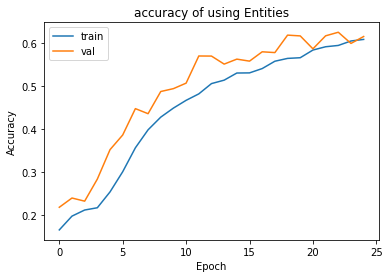

In [ ]:
#plt.plot(loss_train)
plt.plot(acc_train_c)
plt.plot(acc_val_c)
plt.title('accuracy of using Entities')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','val']);

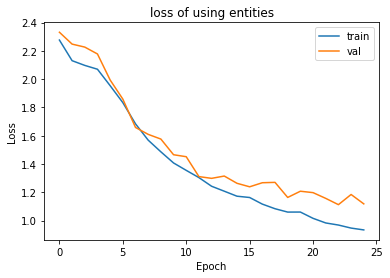

In [ ]:
#plt.plot(loss_train)
plt.plot(loss_train_c)
plt.plot(loss_val_c)
plt.title('loss of using entities')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','val']);

In [ ]:
def visualize_model_c(model):
    y_true = []
    y_pred = []
    running_acc = 0.0
    #with torch.no_grad():
    for i, (sentences,labels,entities)  in enumerate(iter(test_loader)):
            sentences = sentences.to(device)
            labels = labels.to(device)
            entities = entities.to(device)

            outputs = model(sentences,entities)
            outputs_acc = torch.argmax(outputs,dim=1)
            acc = accuracy(labels,outputs_acc)
            running_acc += acc.item()
            for out in outputs_acc:
              y_pred.append(out.tolist())    
            for true in labels:
              y_true.append(true.tolist())


    acc = running_acc / i
    print("test accuray : ",acc)
    recall = recall_score(y_true, y_pred, average='macro')
    print("Recall: " , recall)
    precision = precision_score(y_true, y_pred, average='macro')
    print("Precision: " , precision)
    f1 = f1_score(y_true, y_pred, average='macro')
    print("f1_score: " , f1)
    print("confusion matrix: \n" , confusion_matrix(y_true, y_pred))

In [ ]:
visualize_model_c(model_c)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


test accuray :  0.5324815270446596
Recall:  0.5523925483213605
Precision:  0.4914290776431911
f1_score:  0.5086212967571851
confusion matrix: 
 [[  0  27  82   1 120   9  15   2   5  67]
 [  0  64  21   2  27   4  11   1   2  24]
 [  0   8 141   0  47   4   2   2   4  23]
 [  0   1   4 122   7  35  13   1   1   8]
 [  0   3   9   0 224   8   3   1   2   8]
 [  0   1   1  14   6 246   1   0   3  20]
 [  0  19  13   6  26   4 193  16   9  26]
 [  0   2  14   1   6   2  13 159   3  33]
 [  0   4  24   0  10  12   6   2 170  33]
 [  0  36  52  17  69  67  36  45  39  93]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


random initialization vs using gloves for embedding matrix

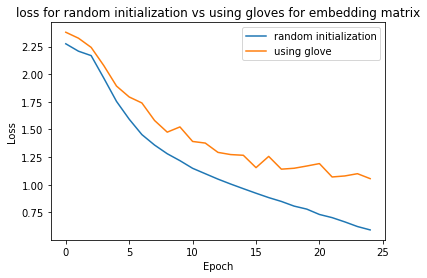

In [ ]:
plt.plot(loss_train_a)
plt.plot(loss_val_b)
plt.title('loss for random initialization vs using gloves for embedding matrix')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['random initialization','using glove']);

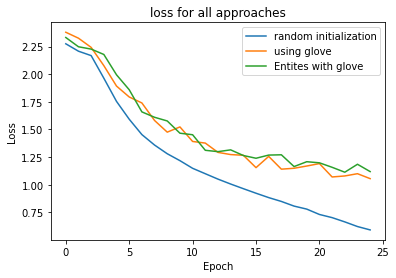

In [ ]:
plt.plot(loss_train_a)
plt.plot(loss_val_b)
plt.plot(loss_val_c)
plt.title('loss for all approaches')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['random initialization','using glove' , 'Entites with glove']);